# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head(3)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
#check duplicates

df_reviews.duplicated().sum()

0

In [8]:
df_reviews[df_reviews["average_rating"].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [9]:
df_reviews[df_reviews["votes"].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


Delete the 2 rows of N/A due to be insignificant in overall dataframe

In [10]:
df_reviews = df_reviews.dropna()  

In [11]:
# check for the class imbalance with value_counts()

df_reviews['pos'].value_counts() 

0    23715
1    23614
Name: pos, dtype: int64

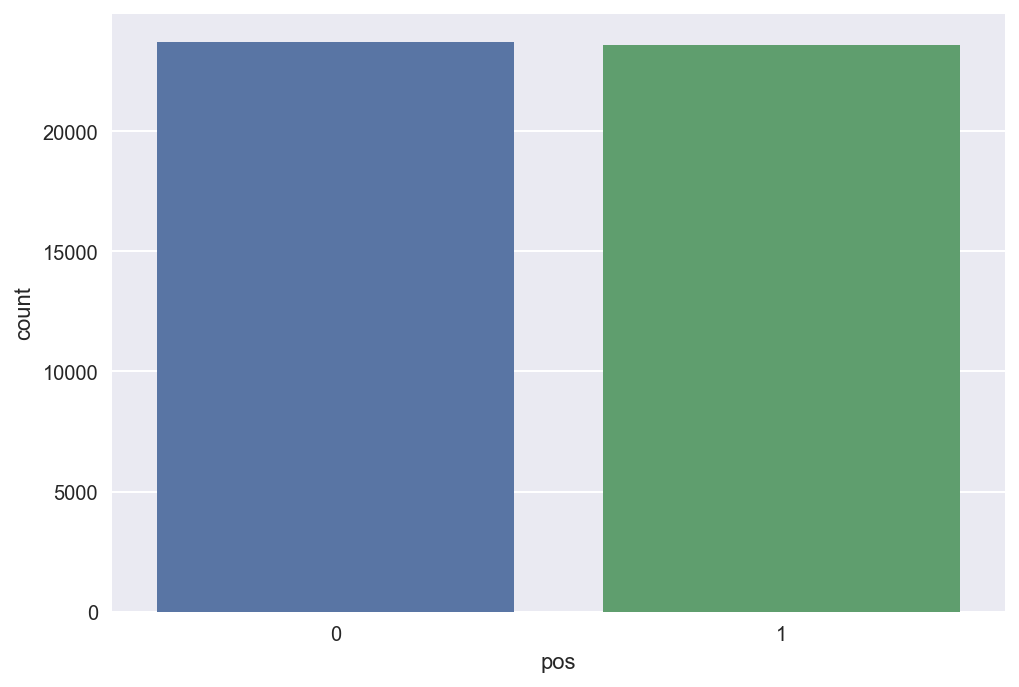

In [12]:
sns.countplot(x='pos', data = df_reviews)
plt.show()

Data for target is well balanced

## EDA

Let's check the number of movies and reviews over years.

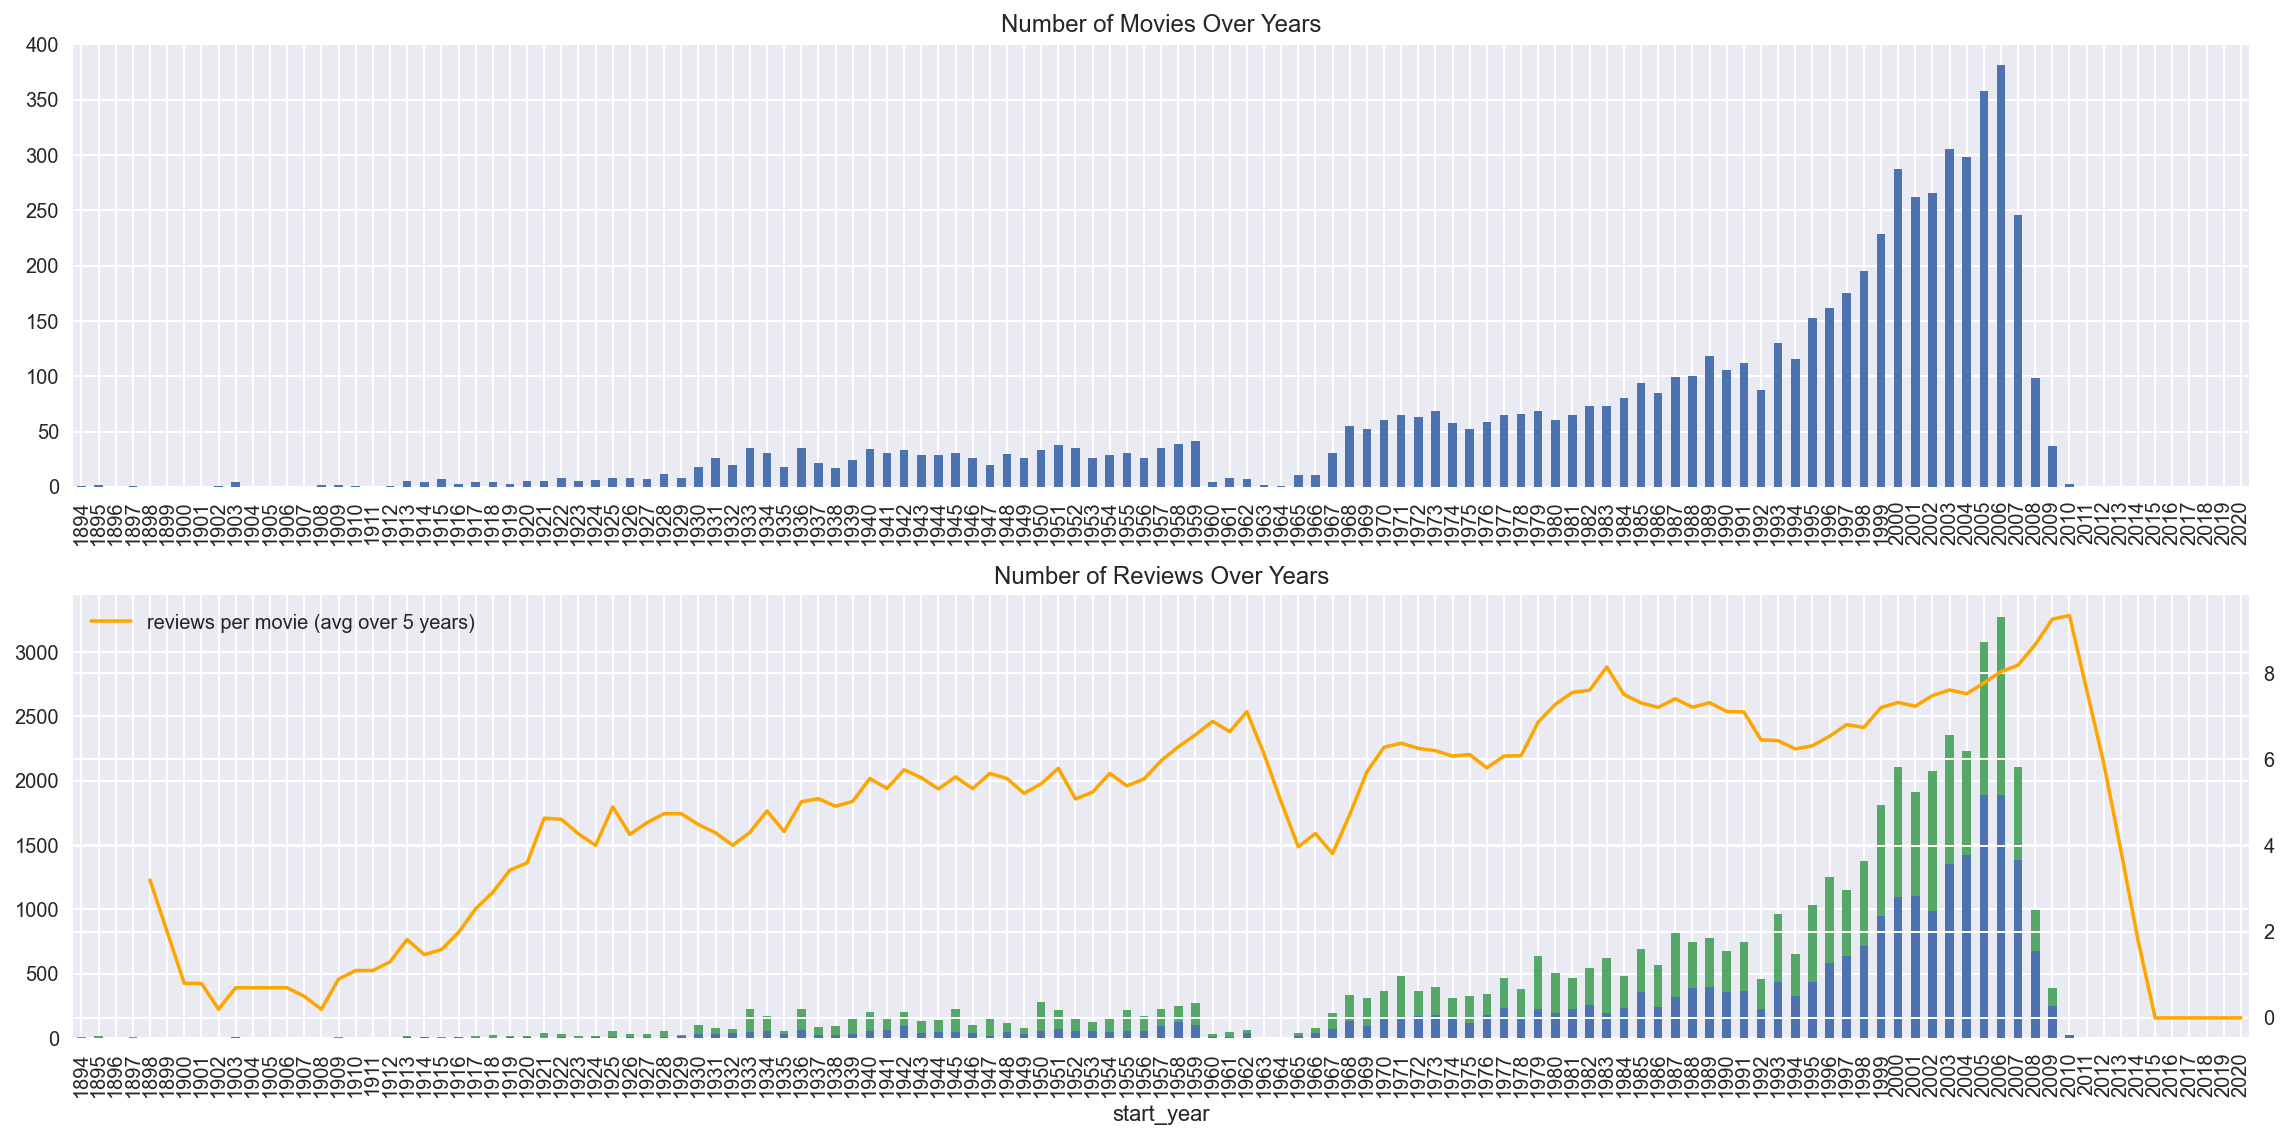

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

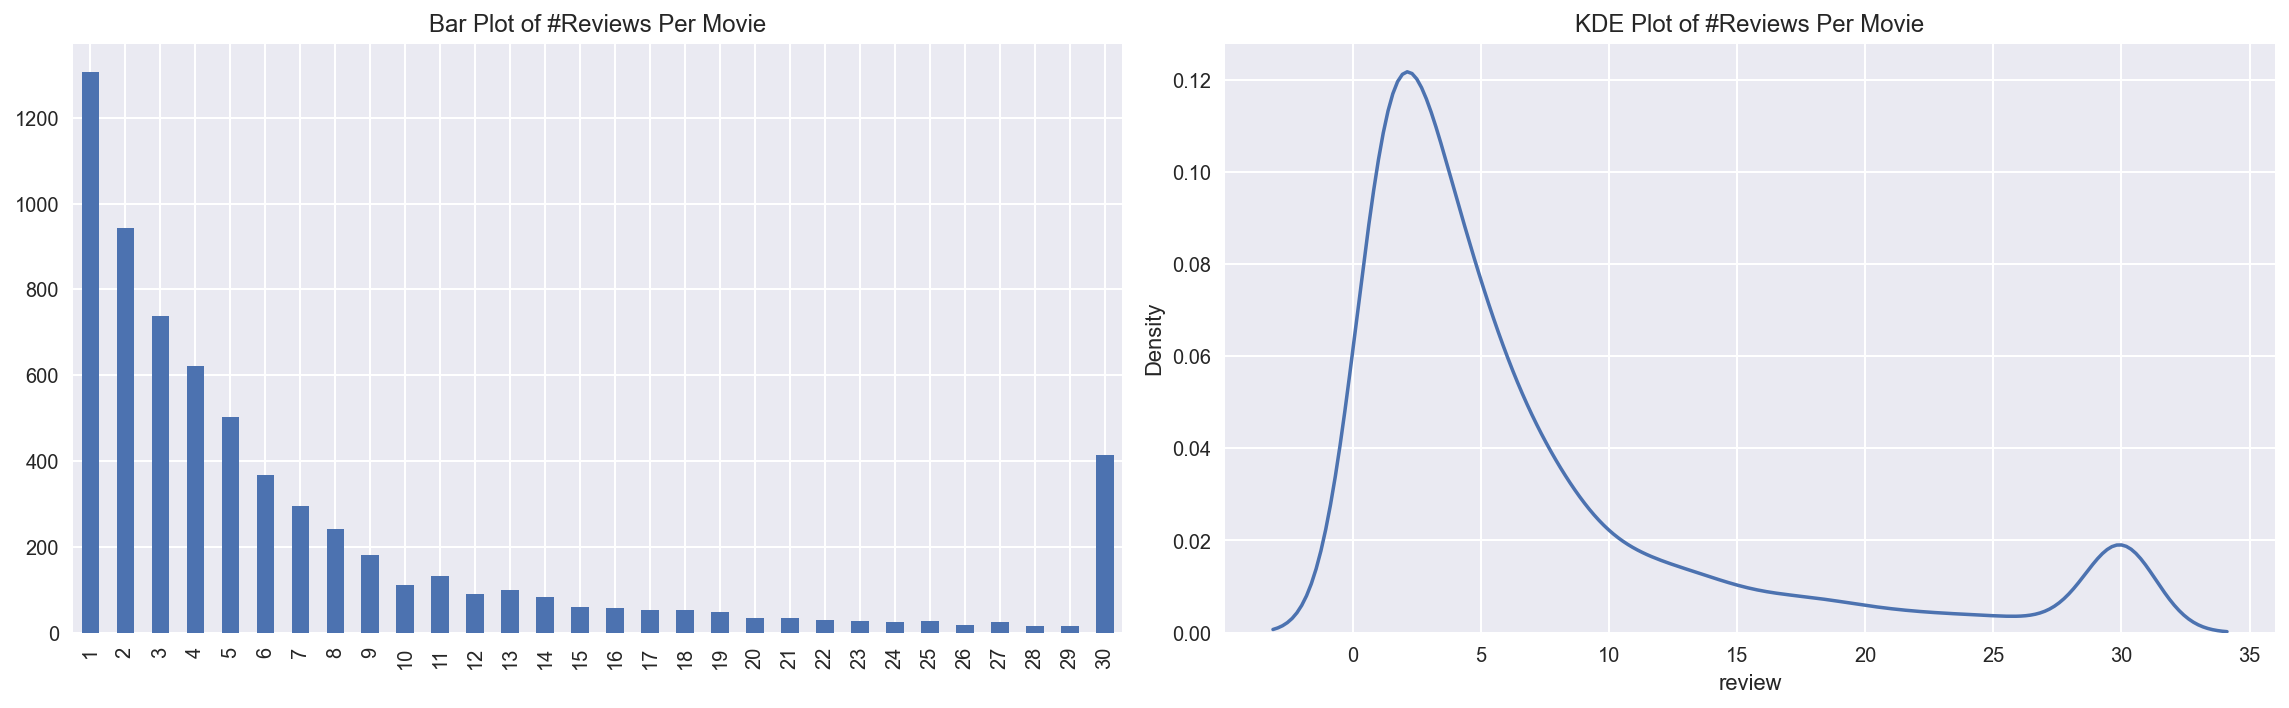

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

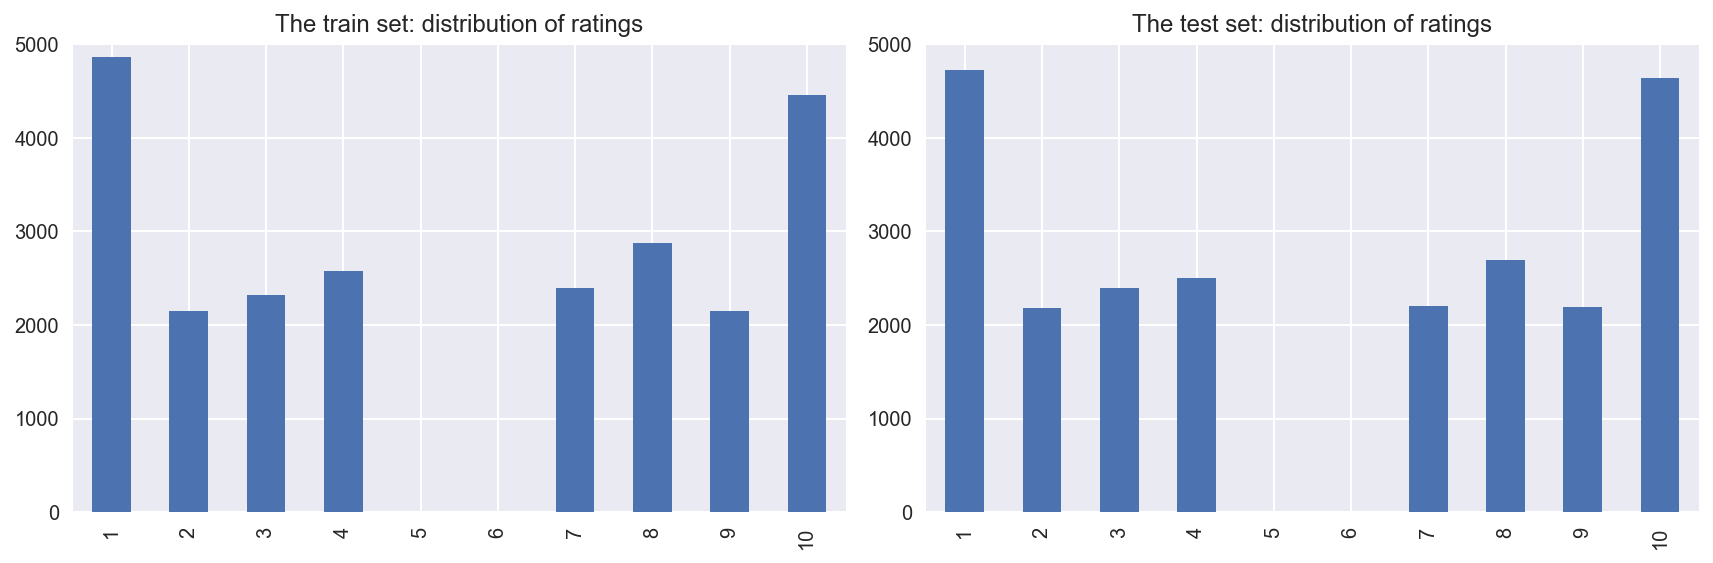

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

C:\Users\pedro\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\pedro\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\pedro\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\pedro\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


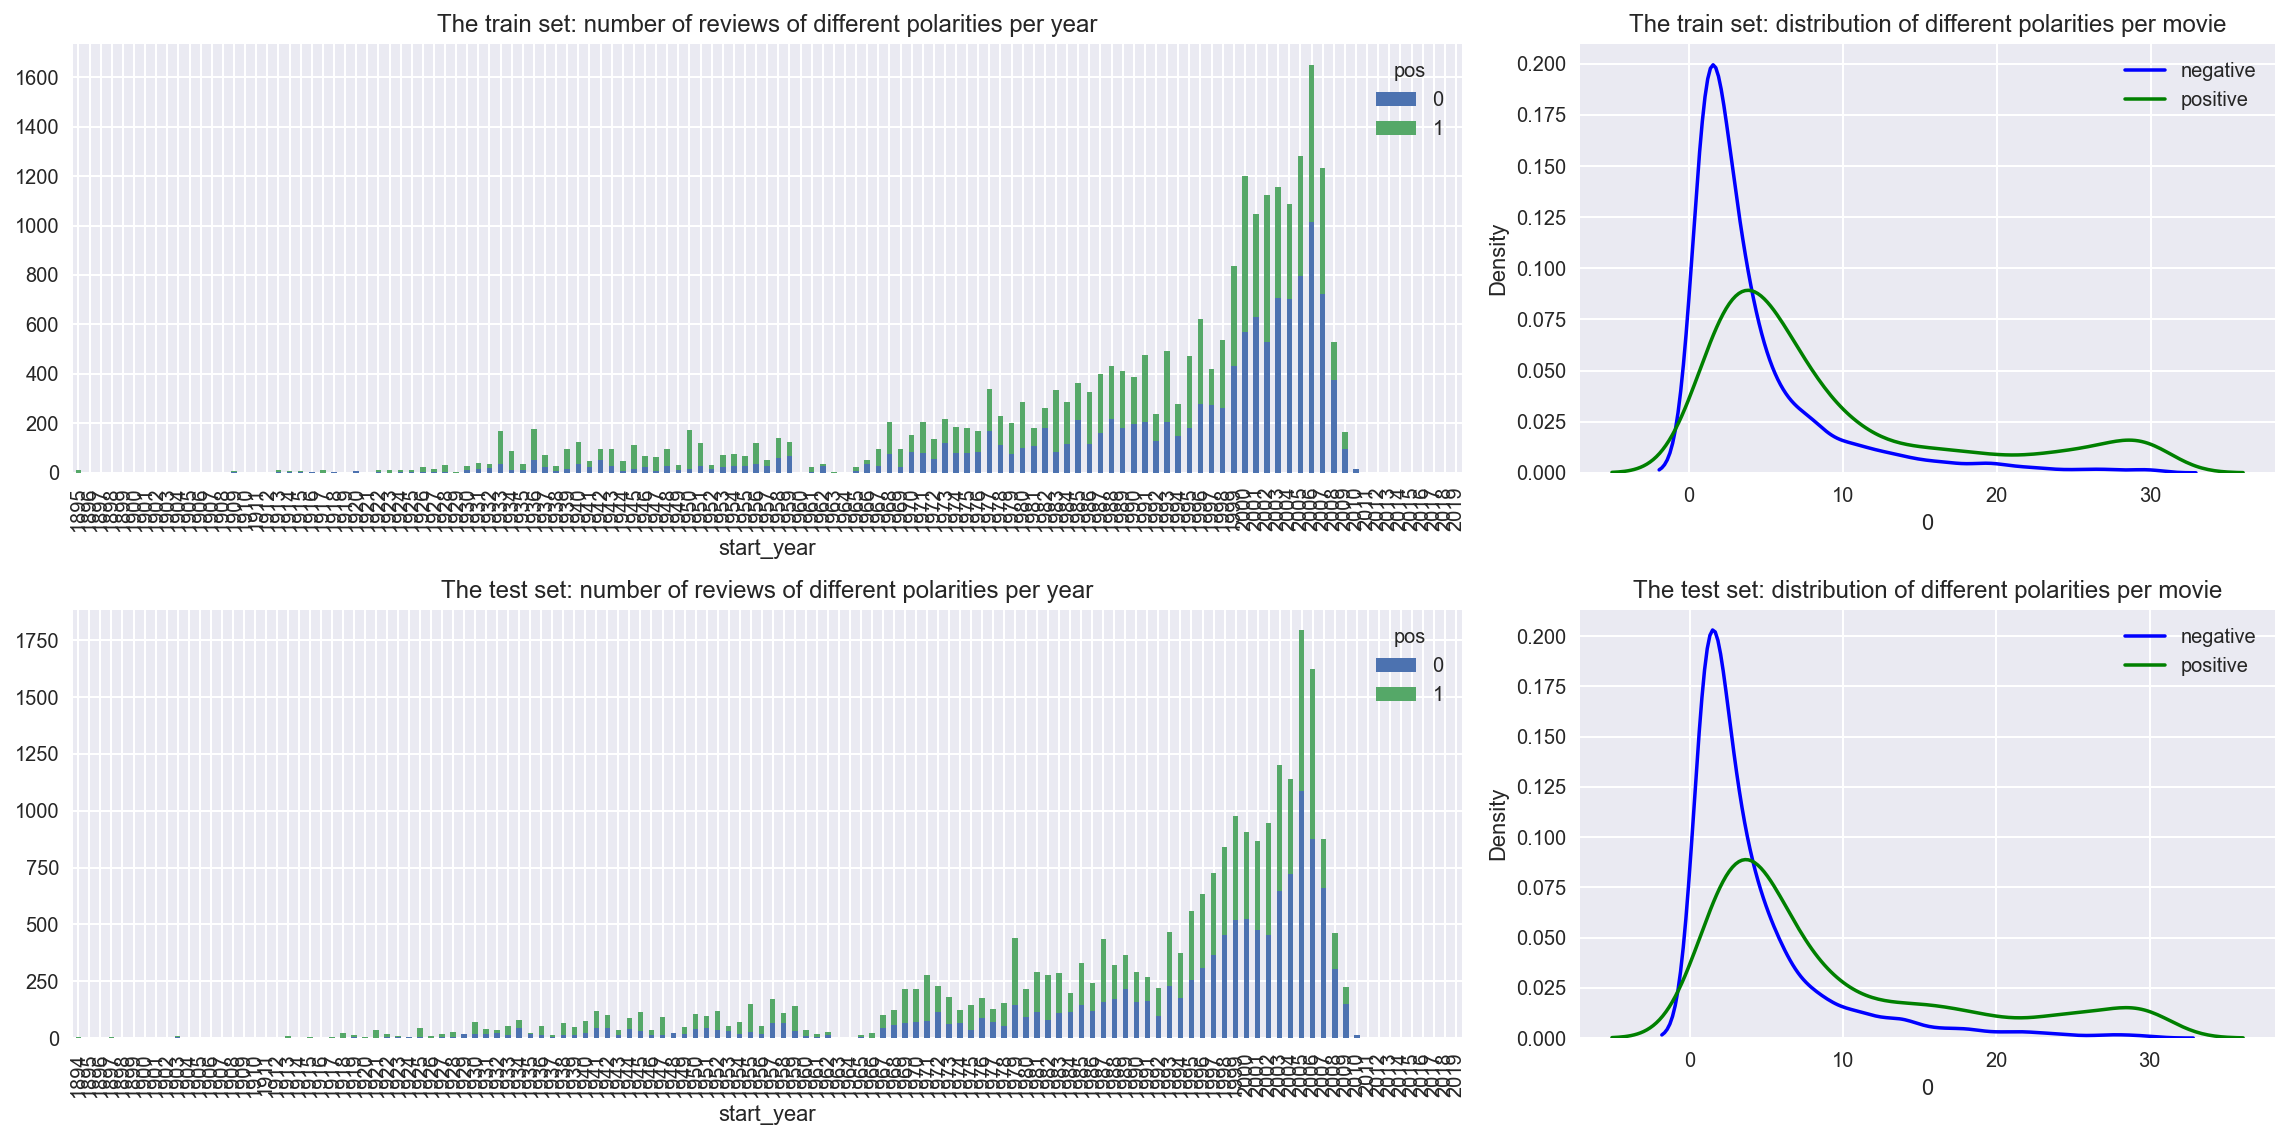

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [17]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [18]:
import re
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clear_text(text):
    
    clean_text = re.sub(r'[^a-zA-Z\']', ' ', text)
    clean_text = " ".join(clean_text.split())

    return clean_text
    

def lemmatize(text):

    doc = nlp(text.lower())
    
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
        
    return ' '.join(lemmas)

In [19]:
def clean_text(text):
    
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    text = " ".join(text)    
    return text

In [20]:
df_reviews['review_norm'] = df_reviews['review'].apply(clean_text)

In [22]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

In [23]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
 17  review_norm 

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [26]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [27]:
train_features =   df_reviews_train.drop('pos', axis=1)
test_features =  df_reviews_test.drop('pos', axis=1)

## Working with models

### Model 0 - Constant

In [28]:
from sklearn.dummy import DummyClassifier

In [29]:
from sklearn.metrics import classification_report

In [33]:
%%time

dummy_model = DummyClassifier()
dummy_model.fit(train_features, train_target)
y_pred = dummy_model.predict(test_features)
#classification_report(test_target, y_pred)
display(pd.DataFrame(classification_report(test_target, y_pred, output_dict=True)).T)

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.501551,1.000000,0.668044,11803.000000
1,0.000000,0.000000,0.000000,11730.000000
accuracy,0.501551,0.501551,0.501551,0.501551
macro avg,0.250776,0.500000,0.334022,23533.000000
weighted avg,0.251553,0.501551,0.335058,23533.000000


Wall time: 33.9 ms


In [34]:
from sklearn.metrics import f1_score 

print('F1:', f1_score(test_target, y_pred))

F1: 0.0


          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


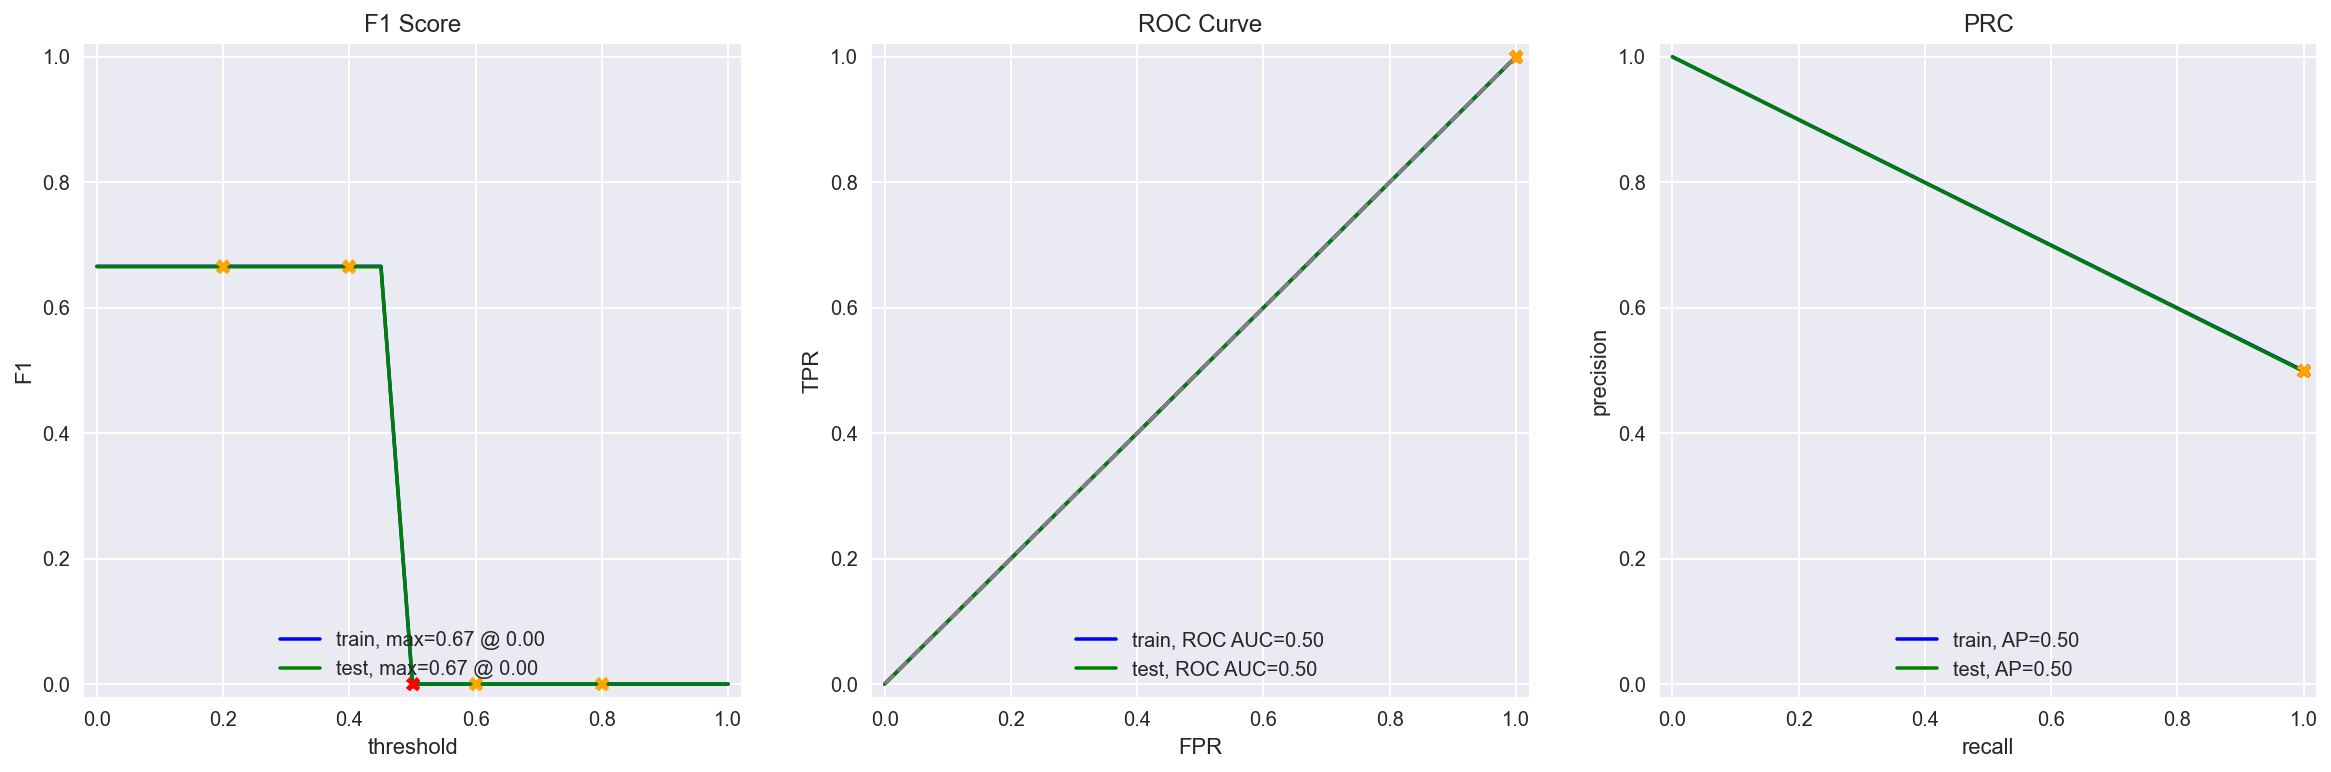

In [35]:
evaluate_model(dummy_model, train_features, train_target, test_features, test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [36]:
import nltk
nltk.download()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [37]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer  = WordNetLemmatizer()

def text_lemma(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

df_reviews_train['review_lemma'] = df_reviews_train['review_norm'].apply(text_lemma)
df_reviews_test['review_lemma'] = df_reviews_test['review_norm'].apply(text_lemma)



In [38]:
stop_words =  set(stopwords.words('english'))
count_tf_idf_nltk = TfidfVectorizer(stop_words=stop_words)
corpus_train = df_reviews_train['review_lemma']
corpus_test = df_reviews_test['review_lemma']

# creating a TF-IDF matrix without stop words
train_features_1 = count_tf_idf_nltk.fit_transform(corpus_train)
test_features_1 = count_tf_idf_nltk.transform(corpus_test)

In [39]:
%%time

model_1 = LogisticRegression()
model_1.fit(train_features_1,train_target)
y_pred = model_1.predict(test_features_1)
#classification_report(test_target, y_pred)
display(pd.DataFrame(classification_report(test_target, y_pred, output_dict=True)).T)

,precision,recall,f1-score,support
0,0.879814,0.880708,0.880261,11803.000000
1,0.879843,0.878943,0.879393,11730.000000
accuracy,0.879828,0.879828,0.879828,0.879828
macro avg,0.879828,0.879826,0.879827,23533.000000
weighted avg,0.879828,0.879828,0.879828,23533.000000


Wall time: 897 ms


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


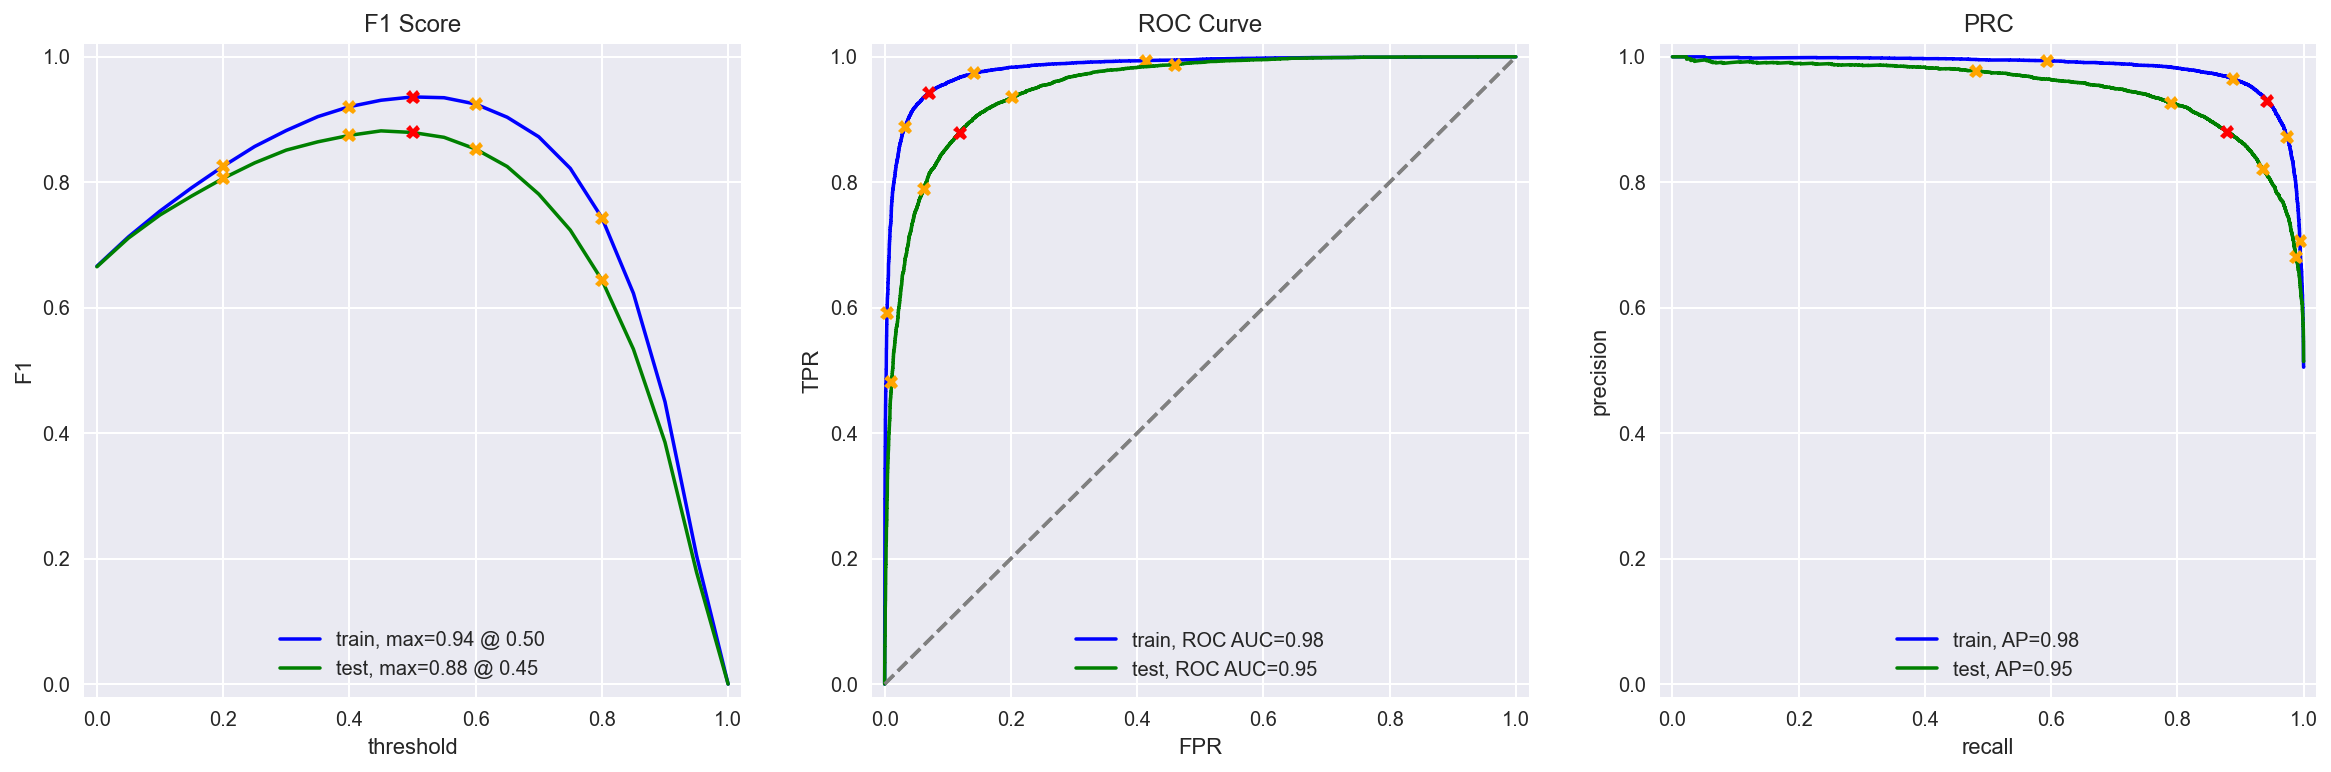

In [40]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [41]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [42]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    #tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [43]:
df_reviews_train['review_preprocessing_3'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_preprocessing_3'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [44]:
count_tf_idf_spacy = TfidfVectorizer()
corpus_train = df_reviews_train['review_preprocessing_3']
corpus_test = df_reviews_test['review_preprocessing_3']

# creating a TF-IDF matrix without stop words
train_features_2 = count_tf_idf_spacy.fit_transform(corpus_train)
test_features_2 = count_tf_idf_spacy.transform(corpus_test)

In [45]:
%%time

model_2 = LogisticRegression()
model_2.fit(train_features_2,train_target)
y_pred = model_2.predict(test_features_2)
#classification_report(test_target, y_pred)
display(pd.DataFrame(classification_report(test_target, y_pred, output_dict=True)).T)

,precision,recall,f1-score,support
0,0.877275,0.873930,0.875600,11803.000000
1,0.873631,0.876982,0.875303,11730.000000
accuracy,0.875451,0.875451,0.875451,0.875451
macro avg,0.875453,0.875456,0.875451,23533.000000
weighted avg,0.875458,0.875451,0.875452,23533.000000


Wall time: 1.3 s


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.94
ROC AUC    0.98  0.95


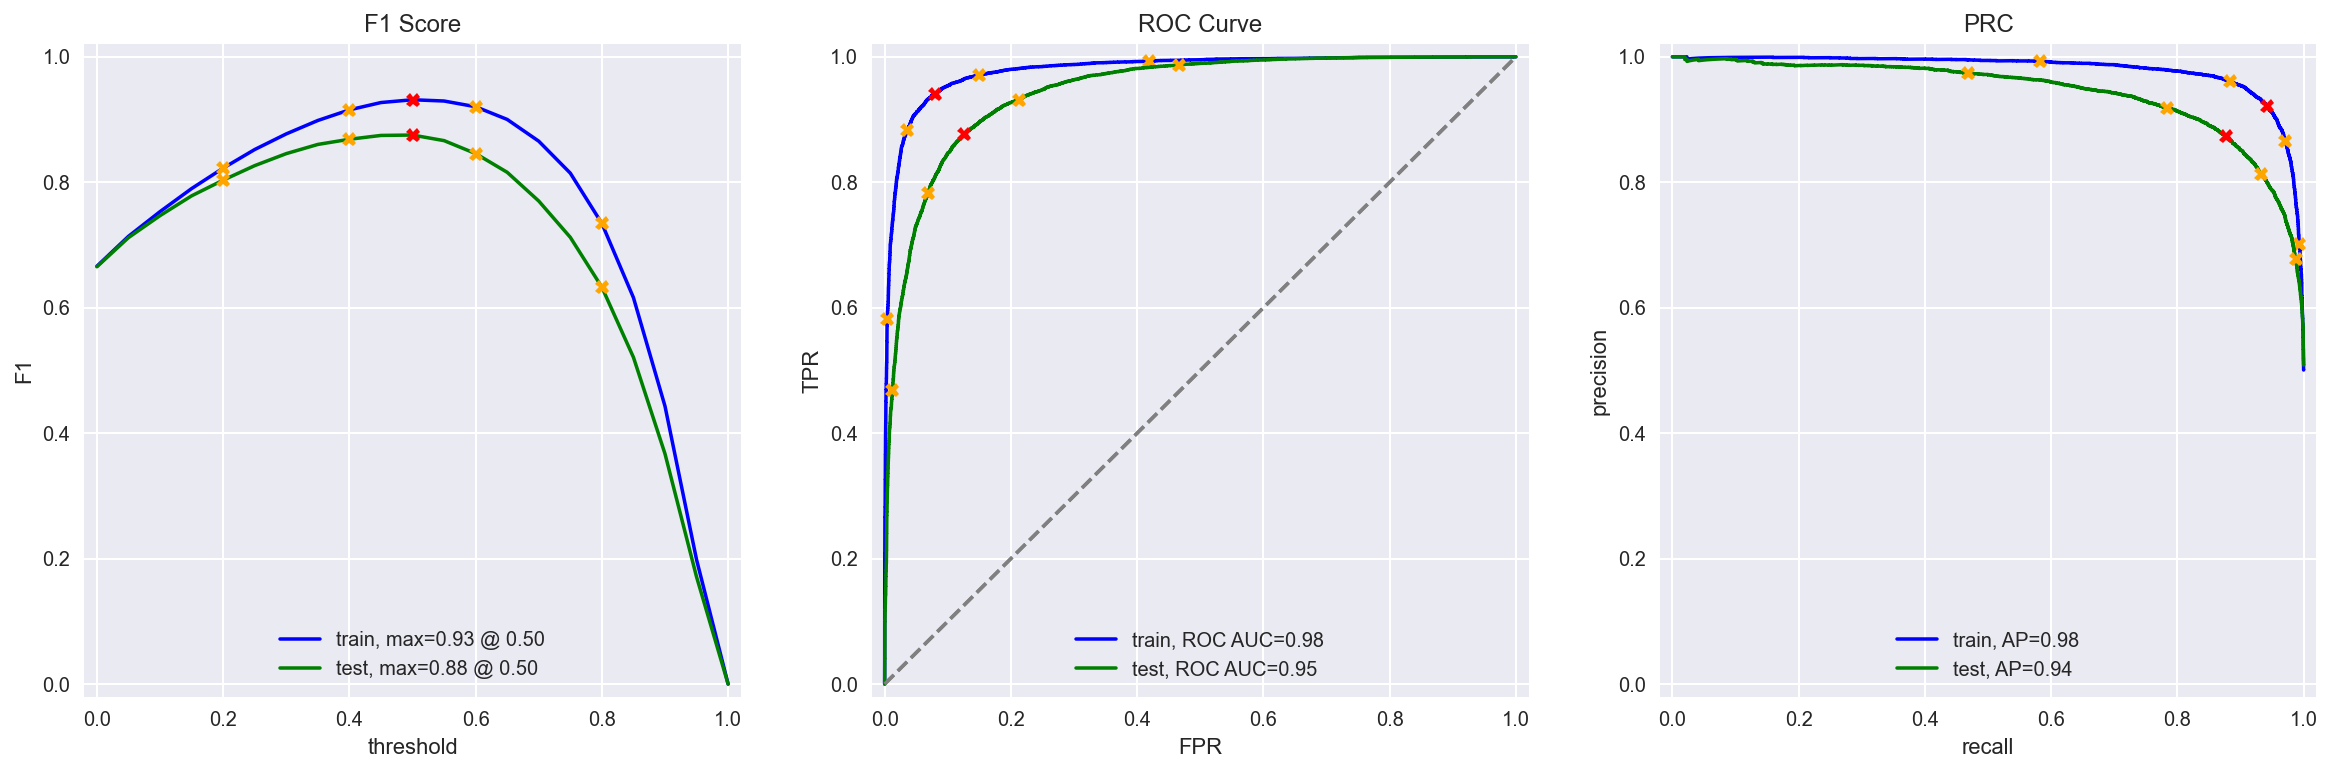

In [46]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [47]:
from lightgbm import LGBMClassifier

In [48]:
# creating a TF-IDF matrix without stop words
train_features_3 = count_tf_idf_spacy.fit_transform(corpus_train)
test_features_3 = count_tf_idf_spacy.transform(corpus_test)

In [49]:
%%time
model_4 = LGBMClassifier()
model_4.fit(train_features_3,train_target)
y_pred = model_4.predict(test_features_3)
#classification_report(test_target, y_pred)
display(pd.DataFrame(classification_report(test_target, y_pred, output_dict=True)).T)

,precision,recall,f1-score,support
0,0.860421,0.845039,0.852661,11803.000000
1,0.846830,0.862063,0.854379,11730.000000
accuracy,0.853525,0.853525,0.853525,0.853525
macro avg,0.853626,0.853551,0.853520,23533.000000
weighted avg,0.853647,0.853525,0.853517,23533.000000


Wall time: 17.3 s


          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


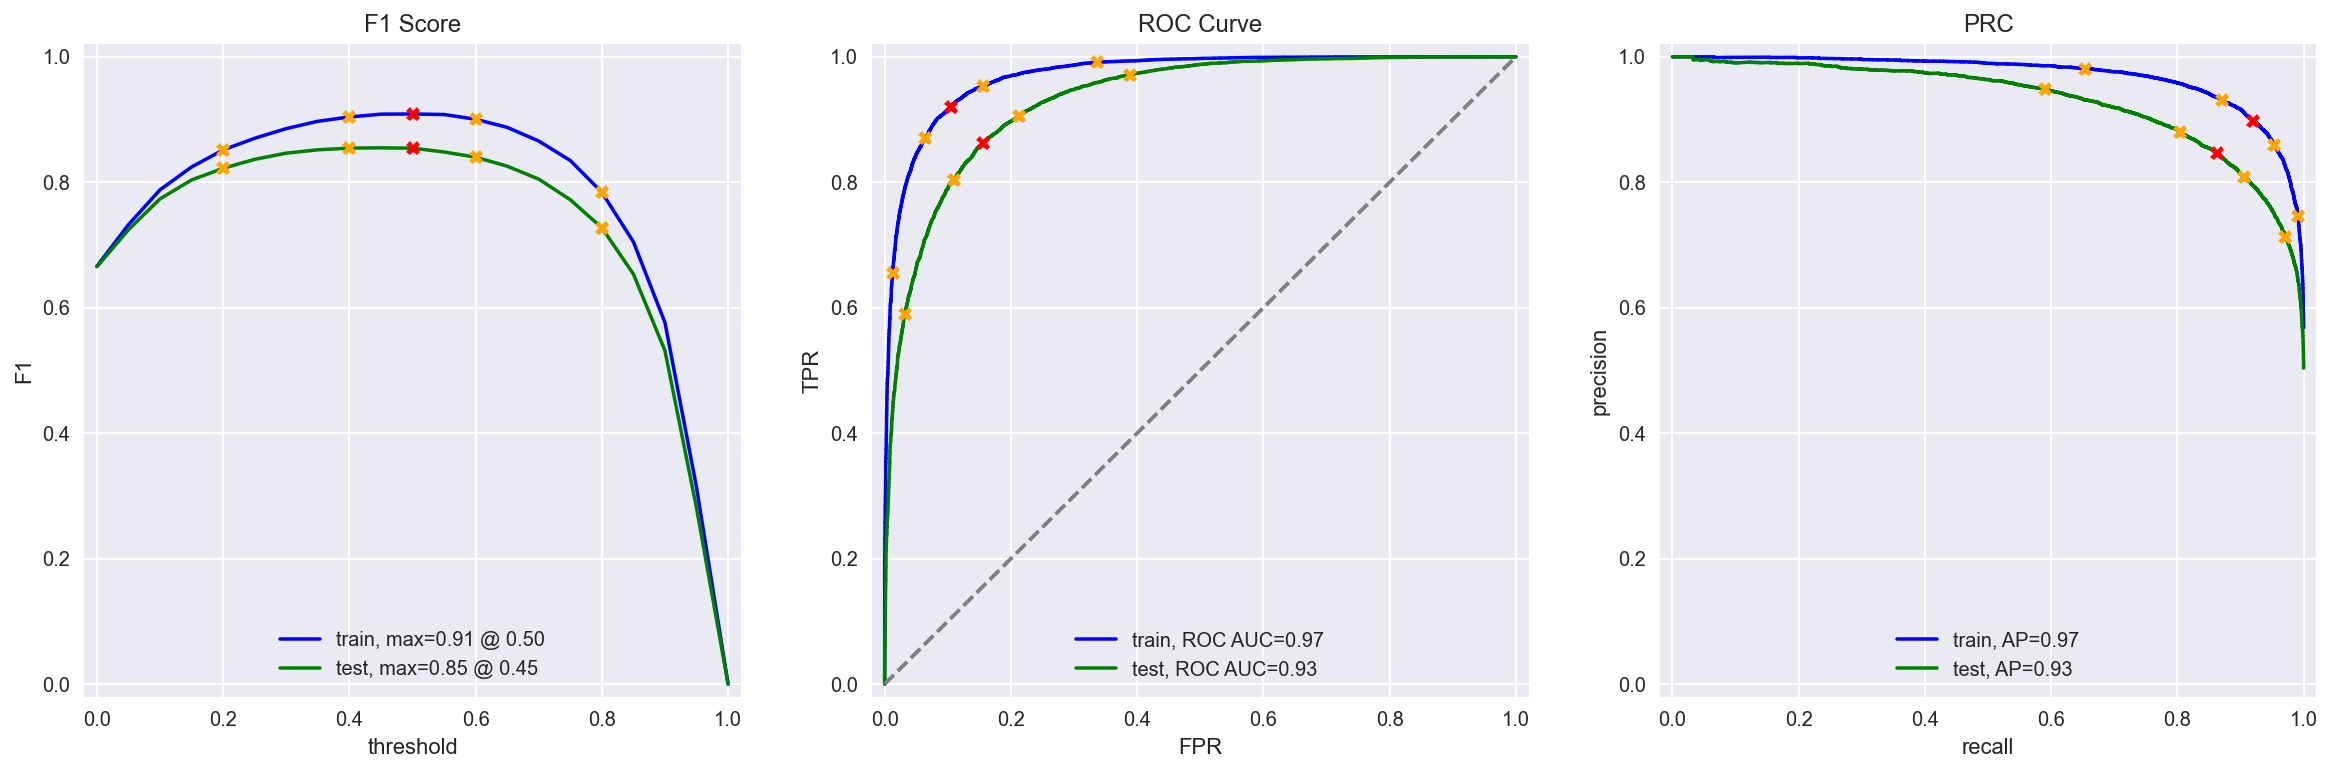

In [50]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

###  Model 9 - BERT

In [51]:
#import torch
#import transformers

In [52]:
#tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
#config = transformers.BertConfig.from_pretrained('bert-base-uncased')
#model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [53]:
"""

def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)
    
"""

"\n\ndef BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):\n    \n    ids_list = []\n    attention_mask_list = []\n\n    # text to padded ids of tokens along with their attention masks\n    \n    # <put your code here to create ids_list and attention_mask_list>\n    \n    if force_device is not None:\n        device = torch.device(force_device)\n    else:\n        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n        \n    model.to(device)\n    if not disable_progress_bar:\n        print(f'Using the {device} device.')\n    \n    # gettings embeddings in batches\n\n    embeddings = []\n\n    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):\n            \n        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)\n        # <put your code here to create attention_mask_batch\n            \n        with torch.no_grad():            \n   

In [54]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [55]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

In [56]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

#### Considerations:

- DummyClassifier shows the worst result;
- NLTK, TF-IDF and LR has best result in the test set with : Accuracy = 0.88, F1 = 0.88, APS = 0.95, ROC AUC = 0.95. Also runs with a good speed.
- The other 2 models also have interesting results.

## My Reviews

In [57]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] =  my_reviews['review'].apply(clean_text) # <put here the same normalization logic as for the main dataset>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [58]:
my_reviews['review_lemma'] = my_reviews['review_norm'].apply(text_lemma)

stop_words = set(stopwords.words('english'))
count_tf_idf_nltk = TfidfVectorizer(stop_words=stop_words)
my_reviews_corpus_train = df_reviews_train['review_lemma']
my_reviews_corpus_test = my_reviews['review_lemma']

# creating a TF-IDF matrix without stop words
my_reviews_train_features_1 = count_tf_idf_nltk.fit_transform(my_reviews_corpus_train)

In [59]:
# creating a TF-IDF matrix without stop words
tfidf_vectorizer_2 = count_tf_idf_nltk.transform(my_reviews_corpus_test)

In [60]:
texts = my_reviews['review_lemma']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_2)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')



0.84:  I did not simply like it, not my kind of movie.
0.86:  Well, I was bored and felt asleep in the middle of the movie.
0.54:  I was really fascinated with the movie
0.88:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.70:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.47:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.96:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.13:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Model 3

In [61]:
my_reviews['review_lemma_3'] = my_reviews['review_norm'].apply(text_preprocessing_3)
count_tf_idf_spacy = TfidfVectorizer()

my_reviews_corpus_train = df_reviews_train['review_preprocessing_3']
my_reviews_corpus_test = my_reviews['review_lemma_3']

# creating a TF-IDF matrix without stop words
my_reviews_train_features_3 = count_tf_idf_spacy.fit_transform(my_reviews_corpus_train)
tfidf_vectorizer_3 = count_tf_idf_spacy.transform(my_reviews_corpus_test)

In [63]:
texts = my_reviews['review_lemma_3']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_3)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')

0.84:  I did not simply like it, not my kind of movie.
0.93:  Well, I was bored and felt asleep in the middle of the movie.
0.50:  I was really fascinated with the movie
0.86:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.77:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.61:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.97:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.10:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Model 4

In [64]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')

0.49:  I did not simply like it, not my kind of movie.
0.74:  Well, I was bored and felt asleep in the middle of the movie.
0.44:  I was really fascinated with the movie
0.61:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.38:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.49:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.69:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.27:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Model 9

In [65]:
"""

texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

"""

"\n\ntexts = my_reviews['review_norm']\n\nmy_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)\n\nmy_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]\n\nfor i, review in enumerate(texts.str.slice(0, 100)):\n    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')\n\n"

## Conclusions

- NLTK, TF-IDF and LR shows the best result;
- Ther other models show very similar results;
- All models run fast, still LGBMClassifier is the slowest when compared with others

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions